In [ ]:

# 3) Configure l'environnement
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4) Télécharge et décompresse le dataset
!kaggle datasets download -d yukundiao/tinyimagenet -p /content/tinyimagenet --unzip

# 5) Vérifie la structure des fichiers
!find /content/tinyimagenet -maxdepth 2 | head -n 20

Dataset URL: https://www.kaggle.com/datasets/yukundiao/tinyimagenet
License(s): unknown
 56% 132M/235M [00:00<00:00, 1.38GB/s]
100% 235M/235M [00:00<00:00, 1.42GB/s]
/content/tinyimagenet
/content/tinyimagenet/tiny-imagenet-200
/content/tinyimagenet/tiny-imagenet-200/wnids.txt
/content/tinyimagenet/tiny-imagenet-200/words.txt
/content/tinyimagenet/tiny-imagenet-200/test
/content/tinyimagenet/tiny-imagenet-200/train
/content/tinyimagenet/tiny-imagenet-200/val


In [ ]:
import os
import shutil

val_dir = '/content/tinyimagenet/tiny-imagenet-200/val'
images_dir = os.path.join(val_dir, 'images')
annotations_file = os.path.join(val_dir, 'val_annotations.txt')

# Crée les dossiers par classe
with open(annotations_file, 'r') as f:
    for line in f:
        img, class_id = line.strip().split('\t')[:2]
        class_dir = os.path.join(val_dir, class_id)
        os.makedirs(class_dir, exist_ok=True)
        src = os.path.join(images_dir, img)
        dst = os.path.join(class_dir, img)
        shutil.move(src, dst)

# Supprime le dossier images
shutil.rmtree(images_dir)


Epoch 1/10


Training       : 100%|██████████| 1563/1563 [00:31<00:00, 49.23it/s]


Train Loss     : 5.0221
Train Accuracy : 2.78%


Testing        : 100%|██████████| 157/157 [00:02<00:00, 55.51it/s]


Test Loss      : 4.7755
Test Accuracy  : 5.08%

Epoch 2/10


Training       : 100%|██████████| 1563/1563 [00:30<00:00, 50.98it/s]


Train Loss     : 4.7077
Train Accuracy : 5.56%


Testing        : 100%|██████████| 157/157 [00:02<00:00, 58.73it/s]


Test Loss      : 4.5420
Test Accuracy  : 7.72%

Epoch 3/10


Training       : 100%|██████████| 1563/1563 [00:30<00:00, 50.47it/s]


Train Loss     : 4.4915
Train Accuracy : 7.89%


Testing        : 100%|██████████| 157/157 [00:02<00:00, 57.80it/s]


Test Loss      : 4.3756
Test Accuracy  : 9.46%

Epoch 4/10


Training       : 100%|██████████| 1563/1563 [00:31<00:00, 50.04it/s]


Train Loss     : 4.3319
Train Accuracy : 10.03%


Testing        : 100%|██████████| 157/157 [00:02<00:00, 54.08it/s]


Test Loss      : 4.2416
Test Accuracy  : 11.09%

Epoch 5/10


Training       : 100%|██████████| 1563/1563 [00:31<00:00, 49.24it/s]


Train Loss     : 4.2185
Train Accuracy : 11.36%


Testing        : 100%|██████████| 157/157 [00:02<00:00, 56.80it/s]


Test Loss      : 4.1544
Test Accuracy  : 12.26%

Epoch 6/10


Training       : 100%|██████████| 1563/1563 [00:31<00:00, 50.11it/s]


Train Loss     : 4.1276
Train Accuracy : 12.69%


Testing        : 100%|██████████| 157/157 [00:02<00:00, 56.93it/s]


Test Loss      : 4.0803
Test Accuracy  : 13.33%

Epoch 7/10


Training       : 100%|██████████| 1563/1563 [00:30<00:00, 50.52it/s]


Train Loss     : 4.0488
Train Accuracy : 13.75%


Testing        : 100%|██████████| 157/157 [00:02<00:00, 56.02it/s]


Test Loss      : 4.0216
Test Accuracy  : 14.16%

Epoch 8/10


Training       : 100%|██████████| 1563/1563 [00:30<00:00, 51.14it/s]


Train Loss     : 3.9853
Train Accuracy : 14.72%


Testing        : 100%|██████████| 157/157 [00:02<00:00, 56.40it/s]


Test Loss      : 3.9745
Test Accuracy  : 14.67%

Epoch 9/10


Training       : 100%|██████████| 1563/1563 [00:30<00:00, 50.98it/s]


Train Loss     : 3.9278
Train Accuracy : 15.48%


Testing        : 100%|██████████| 157/157 [00:02<00:00, 56.16it/s]


Test Loss      : 3.9276
Test Accuracy  : 15.03%

Epoch 10/10


Training       : 100%|██████████| 1563/1563 [00:31<00:00, 50.12it/s]


Train Loss     : 3.8772
Train Accuracy : 16.28%


Testing        : 100%|██████████| 157/157 [00:02<00:00, 55.79it/s]


Test Loss      : 3.8870
Test Accuracy  : 15.81%


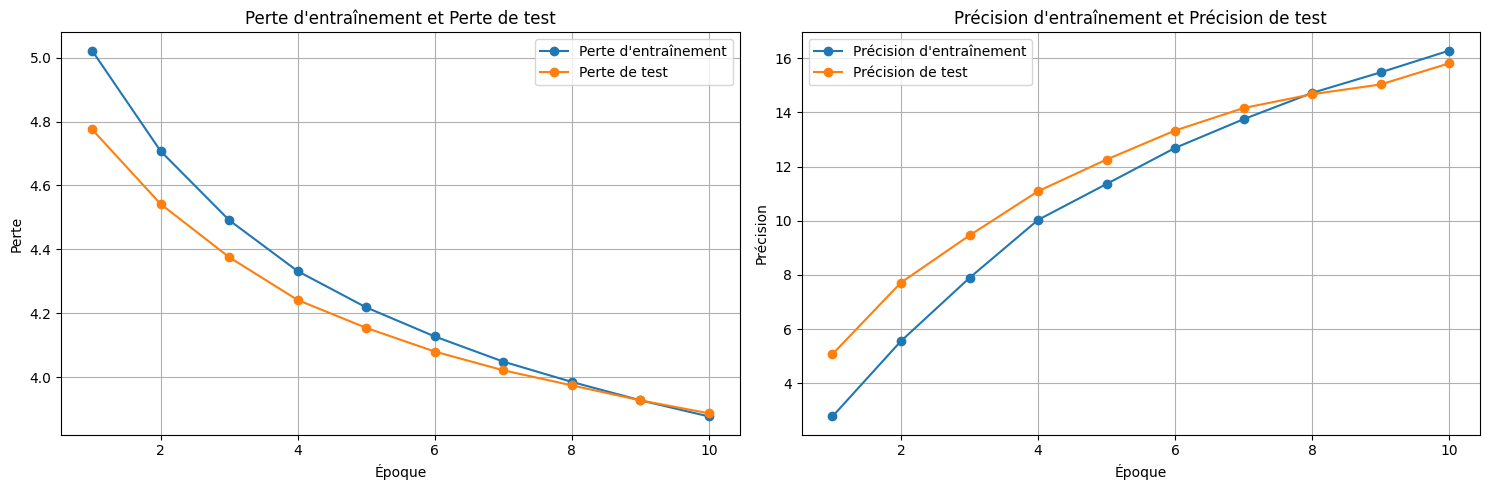

Model saved
Done


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import os
from torchvision.datasets import ImageFolder

# === Configuration ===
img_size = 64
n_channels = 3
patch_size = 16
d_model = 128
num_heads = 4
num_layers = 6
num_classes = 200
ff_dim = 384
dropout = 0.1
lr = 1e-4
batch_size = 32
num_epochs = 10           # Nombre d'époques



class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size

        # Convolution pour extraire les patches et les projeter directement dans l'espace d'embedding
        self.patch_embedding = nn.Conv2d(
            in_channels=n_channels,
            out_channels=d_model,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        N, C, H, W = x.shape

        # Passer l'image à travers la couche de patch embedding
        x = self.patch_embedding(x)           # (N, C, H, W) -> (N, D, H/patch_size, W/patch_size)
        x = x.flatten(2)                      # (N, D, H/patch_size, W/patch_size) -> (N, D, num_patches)
        x = x.transpose(1, 2)                 # (N, D, num_patches) -> (N, num_patches, D)

        return x





class ViT(nn.Module):
    def __init__(self, img_size, n_channels, patch_size, d_model, num_heads, num_layers, num_classes, ff_dim , dropout):
        super(ViT, self).__init__()

        self.patch_embedding = PatchEmbedding(d_model, img_size, patch_size, n_channels)


        # Token CLS à concaténer
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        # Embedding de position pour les patches et CLS token
        num_patches = (img_size // patch_size) ** 2
        self.position_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, d_model)
        )

        # Définition d'une couche Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,      # Dimension des embeddings
            nhead=num_heads,          # Nombre de têtes dans l'attention multi-têtes
            dim_feedforward=ff_dim,  # Dimension des couches feedforward
            dropout=dropout   ,    # Taux de dropout
            batch_first=True
            )

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)


        self.dropout = nn.Dropout(dropout)

        # Couche linéaire finale pour classification
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):

        N, C, H, W = x.shape

        # Passer l'image à travers la couche de patch embedding
        x = self.patch_embedding(x)

        # Concaténer le CLS token
        cls_tokens = self.cls_token.repeat(N, 1, 1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Ajouter les embeddings de position
        x = x + self.position_embedding

        # Passer à travers le Transformer Encoder
        x = self.transformer_encoder(x)


        # Dropout
        x = self.dropout(x)

        # Prendre la sortie du token CLS
        x = x[:, 0]

        # Couche finale pour la classification
        x = self.fc(x)

        return x


# Fonction pour obtenir les DataLoaders
# Fonction pour obtenir les DataLoaders
def get_data_loaders(batch_size=batch_size):

    # 1. Chemin monté automatiquement par Kaggle
    dataset_path = "/content/tinyimagenet/tiny-imagenet-200"


# --- 1. Définir les transformations d'entrée ---
    train_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ])

    test_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ])

    train_dir = os.path.join(dataset_path, "train")
    test_dir = os.path.join(dataset_path, "val")


    train_dataset = ImageFolder(root=train_dir, transform=train_transform)
    test_dataset = ImageFolder(root=test_dir, transform=test_transform)


    trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=2)
    testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

    #trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    #testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


    return trainloader, testloader

# Fonction d'entraînement
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc="Training       "):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return epoch_loss, train_accuracy


# Fonction de test
def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_test_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing        "):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = running_test_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

# Fonction principale
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    trainloader, testloader = get_data_loaders()



    # Initialisation du modèle
    model = ViT(
        img_size=img_size,
        n_channels=n_channels,
        patch_size=patch_size,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        num_classes=num_classes,
        ff_dim=ff_dim,
        dropout=dropout
    )

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    t_train_acc = []
    t_test_acc = []
    t_train_loss = []
    t_test_loss = []

    for epoch in range(num_epochs):

        print(f'\nEpoch {epoch+1}/{num_epochs}')
        train_loss, train_accuracy = train(model, trainloader, optimizer, criterion, device)
        print(f'Train Loss     : {train_loss:.4f}')
        print(f'Train Accuracy : {train_accuracy:.2f}%')
        test_loss, test_accuracy = test(model, testloader, criterion, device)
        print(f'Test Loss      : {test_loss:.4f}')
        print(f'Test Accuracy  : {test_accuracy:.2f}%')

        t_train_acc.append(train_accuracy)
        t_test_acc.append(test_accuracy)
        t_train_loss.append(train_loss)
        t_test_loss.append(test_loss)

    # Visualisation des pertes et des précisions
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Tracé de la perte
    ax[0].plot(range(1, num_epochs + 1), t_train_loss, label='Perte d\'entraînement', marker='o')
    ax[0].plot(range(1, num_epochs + 1), t_test_loss, label='Perte de test', marker='o')
    ax[0].set_xlabel('Époque')
    ax[0].set_ylabel('Perte')
    ax[0].set_title('Perte d\'entraînement et Perte de test')
    ax[0].legend()
    ax[0].grid(True)

    # Tracé de la précision
    ax[1].plot(range(1, num_epochs + 1), t_train_acc, label='Précision d\'entraînement', marker='o')
    ax[1].plot(range(1, num_epochs + 1), t_test_acc, label='Précision de test', marker='o')
    ax[1].set_xlabel('Époque')
    ax[1].set_ylabel('Précision')
    ax[1].set_title('Précision d\'entraînement et Précision de test')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

    torch.save(model, 'model.pth')
    print("Model saved")
    print("Done")


if __name__ == '__main__':
    main()